# HVA PARA XXZ

Implementaremos el algoritmo de [Wiersema et al. (2020)](https://arxiv.org/abs/2008.02941). Utilizaremos también el paquete $\verb|tequila|$.

In [1]:
### IMPORTACIÓN DE PAQUETES ###

import tequila as tq
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import qiskit
import qulacs
import cirq
from cirq.contrib.svg import SVGCircuit

Definimos una semilla para poder replicar los resultados.

In [2]:
# SEMILLA

def seed_gen(string):
    num_str = [ord(letter) - 96 for letter in string]
    # seed must be between 0 and 2**32 - 1
    return(np.mod(int(''.join(map(str,num_str))),2**32 - 1))

np.random.seed(seed_gen('raquel')) 

In [3]:
### INPUT ###

# Número de qubits 

nqubits = 4


# Número de capas

if nqubits==4 or nqubits==6:
    nplayers = 4
if nqubits==8:
    nplayers = 8
if nqubits==10:
    nplayers = 12
if nqubits==12:
    nplayers = 36

# Parámetros del Hamiltoniano

Delta_train = np.linspace(-1.1, 1.1, num=20)
Delta_test = [np.random.uniform(-1.1, 1.1) for i in range(100)]
Delta_test.sort()
lambXXZ = 0.75

# Parámetros de optimización
methods = 'ADAM'
grad_methods = '2-point'
backend = 'qulacs'
lr = 0.01
mthd_opt = {'finite_diff_rel_step': 0.0001}
maxiter = 3000

### Construcción del hamiltoniano

Buscamos minimizar la función de coste asociada a un hamiltoniano $H$ de la forma:

$$H = \sum_{i=1}^n \sigma_i^x \sigma_{i+1}^x + \sigma_i^y \sigma_{i+1}^y + \Delta \sigma_i^z \sigma_{i+1}^z,$$

donde $\Delta$ es el parámetro de anisotropía. El hamiltoniano es ligeramente diferente al de meta-VQE en el sentido de que ahora no tenemos parámetro $\lambda$. Para ello, aplicamos las matrices de Pauli $\sigma^x$, $\sigma^y$ y $\sigma^z$ a los correspondientes cúbits. Por otro lado, vamos a aplicar condiciones de contorno periódicas, por lo que el sumatorio no sólo se limita a los cúbits $q_i$, $q_{i+1}$ con $i \in \{ 1, 2, \dots, n\}$, sino que también se enlazarán los cúbits $q_1$ y $q_n$, es decir, habrá que añadir los términos $\sigma_{n}^x \sigma_{1}^x$ (análogo para $\sigma^y$ y $\sigma^z$).

In [4]:
# Construcción del hamiltoniano

def hamiltonian(numqubits, Delta, lamb):
    
    ham = tq.paulis.X(numqubits-1)*tq.paulis.X(0) 
    ham += tq.paulis.Y(numqubits-1)*tq.paulis.Y(0) 
    ham += Delta*tq.paulis.Z(numqubits-1)*tq.paulis.Z(0)
    #ham += lamb*tq.paulis.Z(numqubits-1)
    for i in range(numqubits-1):
        ham += tq.paulis.X(i)*tq.paulis.X(i+1)
        ham += tq.paulis.Y(i)*tq.paulis.Y(i+1)
        ham += Delta*tq.paulis.Z(i)*tq.paulis.Z(i+1)
        #ham += lamb*tq.paulis.Z(i)
    return(ham)

Calculamos la función que nos da el valor exacto del estado fundamental del hamiltoniano sacando sus autovalores.

In [5]:
# Valor exacto del hamiltoniano

#def exact(numqubits, Delta):
def exact(numqubits, Delta, lamb):
    
    ham = hamiltonian(numqubits, Delta, lamb).to_matrix()
    energ = np.linalg.eig(ham)
    energ_index = np.argmin(energ[0])
    
    return [min(energ[0]),energ[1][energ_index]] 

## ALGORITMO HVA

Buscamos dividir el hamiltoniano en sus componentes pares e impares

$$ H^{even}_{\alpha \alpha} = \sum^{n/2}_{i=1} \sigma_{2i-1}^\alpha \sigma_{2i}^\alpha  \ \ \ \ \ \ \  H^{odd}_{\alpha \alpha} = \sum^{n/2}_{i=1} \sigma_{2i}^\alpha \sigma_{2i+1}^\alpha. $$

Un circuíto que parametrice el hamiltoniano de profundidad $p$ tendría las siguientes puertas

$$ U_{XXZ}(\beta, \gamma) = \prod_{l=1}^{p} G(\theta_{l}, H^{odd}_{zz}) G(\phi_l, H^{odd}_{xx}) G(\phi_l, H^{odd}_{yy}) G(\beta_l, H^{even}_{zz}) G(\gamma_l, H^{even}_{xx}) G(\gamma_l, H^{even}_{yy}) $$
donde

$$G(x,H) = e^{-i \frac{x}{2}H}$$


### Construcción del circuito

Construimos ahora el circuito que nos permitirá evaluar el valor esperado del hamiltoniano. 

Primero, abrimos un circuito vacío.

A continuación, aplicaremos la fórmula de $U_{XXZ}(\beta, \gamma)$, separando puertas pares de impares. Haremos una construcción más sencilla a la hora de programar que la que aparece en el paper, en el que aplican primero todas las puertas ZZ, luego todas las YY y así, sucesivamente. Como cada puerta impar (eq. par) ZZ, YY y XX afecta sólo a dos cúbits de cada vez, podemos poner primero todo el bloque de puertas impares sobre dos cúbits y luego proceder con los siguientes dos cúbits. Repetiremos el proceso con las puertas pares.

Esto es lo que aparece reflejado en el código a continuación. A mayores, en el caso de las puertas impares tendremos que tener cuidado con las condiciones de contorno y añadirlas fuera del bucle. En el caso de las puertas pares, nunca tendremos que enlazar el último cúbit con el primero, por lo que no es necesario. 

----

Utilizamos las puertas personalizadas $\verb|tq.gates.Rp(paulistring, angle)|$ para generar las puertas ZZ, XX e YY. $\verb|tequila|$ hace los siguientes cambios. Para empezar, pone la puerta ZZ en función de RZ, enlazándola con CNOT:

$$ ZZ = CNOT (I\otimes RZ) CNOT $$

Observamos que la puerta de rotación RZ estaría en el segundo cúbit. Luego, hace un cambio de base utilizando puertas de rotación con medios giros $RY(\pi/2)$ y $RX(\pi/2)$ en todos los cúbits para poner XX e YY en función de ZZ. Así,


$$ YY = [Rx(\pi/2) \otimes Rx(\pi/2)] \otimes ZZ \otimes [Rx(\pi/2) \otimes Rx(\pi/2)]  $$
$$ XX = [Ry(\pi/2) \otimes Ry(\pi/2)] \otimes ZZ \otimes [Ry(\pi/2) \otimes Ry(\pi/2)] $$

Más abajo, podemos ver el circuito impreso y comprobar que estas son las puertas que implementa.

In [6]:
### ANSATZ HVA ###

def hva(numqubits, nump):
    
    circuit = tq.QCircuit()
  
    for pi in range(nump):
        
        
        # PUERTAS IMPARES
        
        for qi in range(1, numqubits,2):
            
            theta = tq.Variable(name="theta_z_{}".format(pi))
            psi = tq.Variable(name="psi_xy_{}".format(pi))
            
            if (qi==numqubits-1) and (numqubits%2==0):
                
                circuit += tq.gates.Rp(paulistring = "Z(0)Z({})".format(qi), angle=theta)
                circuit += tq.gates.Rp(paulistring="Y(0)Y({})".format(qi), angle=psi)
                circuit += tq.gates.Rp(paulistring="X(0)X({})".format(qi), angle=psi)
                
            else:

                circuit += tq.gates.Rp(paulistring = "Z({})Z({})".format(qi,qi+1), angle=theta)
                circuit += tq.gates.Rp(paulistring="Y({})Y({})".format(qi,qi+1), angle=psi)
                circuit += tq.gates.Rp(paulistring="X({})X({})".format(qi,qi+1), angle=psi)
            
        
        # Puertas PARES
                
        for qi in range(0, numqubits-1,2):
            
            beta = tq.Variable(name="beta_z_{}".format(pi))
            gamma = tq.Variable(name="gamma_xy_{}".format(pi))

            circuit += tq.gates.Rp(paulistring="Z({})Z({})".format(qi,qi+1), angle=beta)
            circuit += tq.gates.Rp(paulistring="Y({})Y({})".format(qi,qi+1), angle=gamma)      
            circuit += tq.gates.Rp(paulistring="x({})X({})".format(qi,qi+1), angle=gamma)       
           
    return(circuit)

Inicializaremos el circuito al estado fundamental del hamiltoniano par:

$$ |\Psi_0 \rangle = \frac{1}{\sqrt{2}} (|01\rangle - |10\rangle) \otimes \frac{1}{\sqrt{2}} (|01\rangle - |10\rangle) \otimes ... $$

In [7]:
# Construcción del circuito 

fullhva = tq.QCircuit()

for qi in range(nqubits):
    fullhva += tq.circuit.gates.X(qi)
    
for qi in range(0,nqubits-1,2):
    fullhva += tq.circuit.gates.H(qi)
    fullhva += tq.circuit.gates.CNOT(control=qi, target=qi+1)
    
fullhva += hva(nqubits, nplayers)


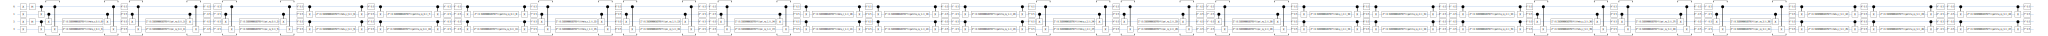

In [8]:
compfullhva = tq.compile(fullhva, backend="cirq").circuit
SVGCircuit(compfullhva)

### Función de coste

De nuevo, la función de coste no será más que el valor esperado del hamiltoniano sobre el estado del circuito. Haremos una sola minimización directamente.

$$ C_i(\vec{\Theta}) = \langle \varphi (\vec{\Theta}_i) | H (\Delta_i) | \varphi_i (\vec{\Theta}_i) \rangle $$

Observamos que, con respecto al meta-VQE, ahora el circuito no depende del parámetro $\Delta_i$.

---

Tendremos en cuenta dos posibles inicializaciones: una de ellas al circuito unidad (todos los ángulos a $\pi$), que asegura la convergencia al estado fundamental; otra, la iniciación aleatoria, que en el régimen de sobreparametrización, también convergería adecuadamente.

In [9]:
# OPTIMIZACIÓN

x_train = Delta_train
y_optHVA = []
error_optHVA = []

for i in range(len(Delta_train)):
    
    ham = hamiltonian(nqubits, Delta_train[i], lambXXZ)
    costf = tq.ExpectationValue(H=ham, U=fullhva)
    
    variables = costf.extract_variables()
    variables = sorted(variables, key=lambda x: x.name)
    
    th0 = {key: np.random.uniform(0, 2*np.pi) for key in variables}
    
    #th0 = {key: np.pi for key in variables}
    
    optHVA = tq.minimize(objective=costf, adaptive = True, lr=lr, method_options=mthd_opt, method=methods, gradient=grad_methods,
                            samples=None, initial_values=th0, backend=backend, noise=None, device=None, silent=True)
    
    res = optHVA.energy
    res_exact = exact(nqubits, Delta_train[i], lambXXZ)[0]
    
    y_optHVA.append(res)
    error_optHVA.append(abs(res - res_exact))

In [10]:
x_test = Delta_test
y_test_exact = []

for i in range(len(Delta_test)):
    
    res_exact = exact(nqubits, Delta_test[i], lambXXZ)[0]
    y_test_exact.append(res_exact.real)

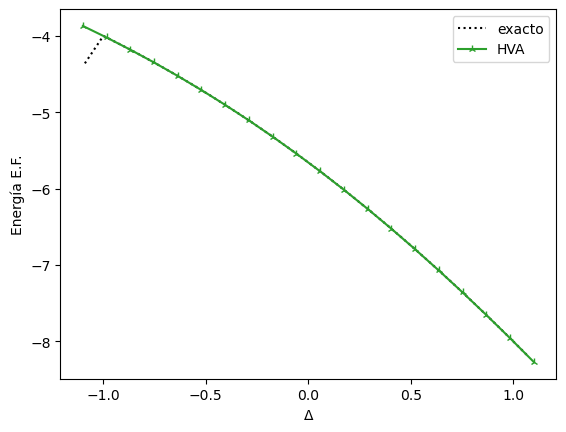

In [11]:
### GRÁFICAS OPT-META-VQE ###

x_train = Delta_train
plt.plot(x_test, y_test_exact, color="black", ls=":", label="exacto")
plt.plot(x_train, y_optHVA,  marker="2", color= 'tab:green', label="HVA")

plt.xlabel("Δ")
plt.ylabel('Energía E.F.')
plt.legend()
plt.savefig('hva_6q', format='svg')
plt.show()

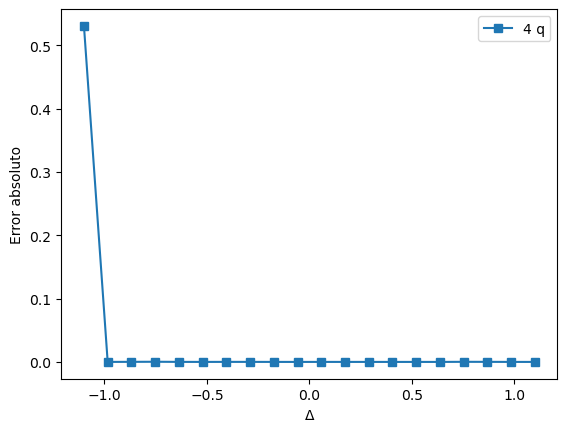

In [12]:
### GRÁFICAS OPT-META-VQE ###

x_train = Delta_train
plt.plot(x_train, error_optHVA,  marker="s", color= 'tab:blue', label="4 q")

plt.xlabel("Δ")
plt.ylabel('Error absoluto')
plt.legend()
plt.savefig('hva_error.svg', format='svg')
plt.show()